#### Use a DataSetLoader class that will return a tf.data.Dataset collection of image and mask pairs. Additionally, it allows to do several image augmentation.

In [139]:
import tensorflow as tf
import numpy as np
import IPython.display as display
import matplotlib.pyplot as plt
from PIL import Image
import shutil, glob, json, os, time
import pathlib
import tarfile
import random

#import tensorflow_addons as tfa
import matplotlib.pyplot as plt

AUTOTUNE = tf.data.experimental.AUTOTUNE

def extract_dataset_archive(archive_file, output_dir):
    with tarfile.open(archive_file, mode = 'r:gz') as tar:
        tar.extractall(output_dir)

def load_image_paths(working_data_dir = 'train_dataset'):
    mask_paths = []
    image_paths = []

    for file in glob.glob(working_data_dir + os.sep + 'images' + os.sep + '*.jpg'):
        mask_file = working_data_dir + os.sep + 'masks' + os.sep + to_mask_file_name(file)
        if (os.path.exists(mask_file)):
            mask_paths.append(mask_file)
            image_paths.append(file)

    print('load {} images'.format(len(mask_paths)))
    return image_paths, mask_paths

def to_mask_file_name(file_name):
    file_name = os.path.basename(file_name)
    name, ext = os.path.splitext(file_name)
    return name + '_mask' + ext

class DataSetLoader(object):
    """ Creates a TensorFlow DataSet that can be used in image semantic segmentation  """
    def __init__(self, image_paths, mask_paths, image_size, channels=[3, 3]):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_size = image_size
        self.channels = channels

    def _normalize_img(self, image, mask):
        #image = tf.image.convert_image_dtype(image, dtype=tf.float32)
        #mask = tf.image.convert_image_dtype(mask,  dtype=np.uint8)
        image = tf.cast(image, tf.float32) / 255.0
        mask = tf.cast(mask, tf.float32) / 255.0
        return image, mask

    def _resize_img(self, image, mask):
        image = tf.image.resize(image, self.image_size)
        mask = tf.image.resize(mask, self.image_size, method='nearest')
        return image, mask

    def _flip_img(self, image, mask):
        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_left_right(image)
            mask = tf.image.flip_left_right(mask)
        return image, mask

    def _rotate_img(self, image, mask, angle):
        image = tfa.image.rotate(image, angle)
        mask = tfa.image.rotate(mask, angle)
        return image, mask

    def _decode_img(self, img_path, ch):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, self.channels[ch])
        return img

    def _load_img(self, image_path, mask_path):
        image = self._decode_img(image_path, 0)
        mask = self._decode_img(mask_path, 1)
        # convert mask to black-white image
        #mask = 1.0 - tf.image.rgb_to_grayscale(mask)
        return self._flip_img(image, mask)

    def data_batch(self, batch_size, shuffle=True, rotate_angle=tf.constant(0.0 * np.pi/6), normalize=False):
        """ Converts input images into TensorFlow 2.0 numpy based DataSet """

        # Creates a Dataset whose elements are slices of the given tensors
        data = tf.data.Dataset.from_tensor_slices((self.image_paths, self.mask_paths))

        # Converts DataSet into Image/Mask DataSet
        data = data.map(self._load_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

        # Resize images
        data = data.map(self._resize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

        # Normalize data
        if normalize:
            data = data.map(self._normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

        # Rotate images
        if (rotate_angle != tf.constant(0.0)):
             data = data.map(lambda img, mask: self._resize_img(img, mask, rotate_angle),\
                             num_parallel_calls=tf.data.experimental.AUTOTUNE)

        # Prefetch and batch data
        if shuffle:
            # Prefetch, shuffle and batch data
            data = data.prefetch(tf.data.experimental.AUTOTUNE)\
            .shuffle(random.randint(0, len(self.image_paths))).batch(batch_size)
        else:
            data = data.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

        return data

#### Use the NWPU images for training and S2 images for testing

In [133]:
train_data_dir = 'nwpu_train_dataset'
test_data_dir = 'train_dataset'

extract_dataset_archive('nwpu_train_dataset.tar.gz', train_data_dir)
extract_dataset_archive('s2_train_dataset.tar.gz', test_data_dir)

In [134]:
train_image_paths, train_mask_paths = load_image_paths(train_data_dir)
test_image_paths, test_mask_paths = load_image_paths(test_data_dir)

load 70 images
load 38 images


In [141]:
BATCH_SIZE = 8
IMG_SIZE = 124
CHANNEL_SIZE = 3

# Train DataSet
train_dataset_loader = DataSetLoader(image_paths=train_image_paths,
                                     mask_paths=train_mask_paths,
                                     image_size=(IMG_SIZE, IMG_SIZE),
                                     channels=[CHANNEL_SIZE, CHANNEL_SIZE])

train_dataset = train_dataset_loader.data_batch(batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                normalize=True)
# Test DataSet
test_dataset_loader = DataSetLoader(image_paths=test_image_paths,
                                    mask_paths=test_mask_paths,
                                    image_size=(IMG_SIZE, IMG_SIZE),
                                    channels=[CHANNEL_SIZE, CHANNEL_SIZE])

test_dataset = train_dataset_loader.data_batch(batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               normalize=True)
for image, mask in train_dataset.take(1):
    print("train dataset shapes:", image.numpy().shape, mask.numpy().shape)

for image, mask in test_dataset.take(1):
    print("test dataset shapes:", image.numpy().shape, mask.numpy().shape)
    

train dataset shapes: (8, 124, 124, 3) (8, 124, 124, 3)
test dataset shapes: (8, 124, 124, 3) (8, 124, 124, 3)


#### Modify the autoencoder net to accept  for 3 channels images or 4D Tensors

In [175]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

# make a python class 
class Deep_Autoencoder():
    
    def __init__(self, image_shape):    
        
        ## the Encoding part
        # use grayscale only so W x H x 1
        in_ = Input(shape=image_shape)
        print(image_shape)
        # 2d convolution layer with 32 output filters in the convolution, 
        # 3x3 pixel kernel, and Relu activation
        # _ = Conv2D(32, (3, 3), activation='relu', input_shape = (28, 28, 3))
        _ = Conv2D(32, (3, 3), activation='relu', padding='same')(in_)
        print(_.shape)
        #'_' is being used as a intermediate variable that is overwritten in each layer
        _ = MaxPooling2D((2, 2), padding='same')(_)
        # a smaller convolutional block with 16 filters
        _ = Conv2D(16, (3, 3), activation='relu', padding='same')(_)
        # max pooling layer
        _ = MaxPooling2D((2, 2), padding='same')(_)
        # a third convolutional block
        _ = Conv2D(16, (3, 3), activation='relu', padding='same')(_)
        
        ## The "Code" is the output of the 2nd max pooling
        code = MaxPooling2D((2, 2), padding='same')(_)
        
        ## The Decoding part is the inverse operation to the above
        _ = Conv2D(16, (3, 3), activation='relu', padding='same')(code)
        _ = UpSampling2D((2, 2))(_)
        _ = Conv2D(16, (3, 3), activation='relu', padding='same')(_)
        _ = UpSampling2D((2, 2))(_)
        _ = Conv2D(32, (3, 3), activation='relu')(_)
        _ = UpSampling2D((2, 2))(_)
        out_ = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(_)
        
        # set up model inputs and outputs, solver (RMSprop) and loss function
        self._model = Model(in_, out_)
        self._model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    # train is a callable function of the Deep_Autoencoder class object   
    # for training the model
    # support tf.data.Dataset
    def do_training(self, in_train, in_test=None, in_validation_data=None, batch_size=8, num_epochs=100):

        # `batch_size` argument must not be specified for the given input type Dataset
        if (isinstance(in_train, tf.data.Dataset)):
            batch_size = None

        self._model.fit(in_train,
                        in_test,
                        verbose = 1,
                        epochs = num_epochs,
                        batch_size = batch_size,
                        shuffle = True,
                        validation_data = in_validation_data,
                       )
        
    # returns a model prediction (a decoded image)
    def get_image(self, encoded_images):
        decoded_images = self._model.predict(encoded_images)
        return decoded_images

    # evaluate model
    def evaluate(self, test_dataset):
        test_loss, test_acc = self._model.evaluate(test_dataset)
        return test_acc

In [176]:
dae = Deep_Autoencoder([IMG_SIZE, IMG_SIZE, CHANNEL_SIZE])

[124, 124, 3]
(None, 124, 124, 32)


In [177]:
dae.do_training(in_train=train_dataset, batch_size=8, num_epochs=10)

Epoch 1/10
9/9 [==============================] - 6s 661ms/step - loss: 0.6231 - accuracy: 0.2389
Epoch 2/10
9/9 [==============================] - 4s 435ms/step - loss: 0.5764 - accuracy: 0.2392
Epoch 3/10
9/9 [==============================] - 3s 368ms/step - loss: 0.5788 - accuracy: 0.2392
Epoch 4/10
9/9 [==============================] - 4s 416ms/step - loss: 0.5775 - accuracy: 0.2397
Epoch 5/10
9/9 [==============================] - 4s 399ms/step - loss: 0.5561 - accuracy: 0.2401
Epoch 6/10
9/9 [==============================] - 4s 452ms/step - loss: 0.5626 - accuracy: 0.2408
Epoch 7/10
9/9 [==============================] - 3s 355ms/step - loss: 0.5419 - accuracy: 0.2325
Epoch 8/10
9/9 [==============================] - 3s 380ms/step - loss: 0.5181 - accuracy: 0.2378
Epoch 9/10
9/9 [==============================] - 4s 393ms/step - loss: 0.5150 - accuracy: 0.2386
Epoch 10/10
9/9 [==============================] - 3s 348ms/step - loss: 0.5171 - accuracy: 0.2363


In [166]:
decoded_imgs = dae.get_image(test_dataset)
test_acc = dae.evaluate(test_dataset)
test_acc

9/9 [==============================] - 1s 97ms/step - loss: 0.5089 - accuracy: 0.2401


0.24013174

/mnt/d/anaconda3/envs/liveproject/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


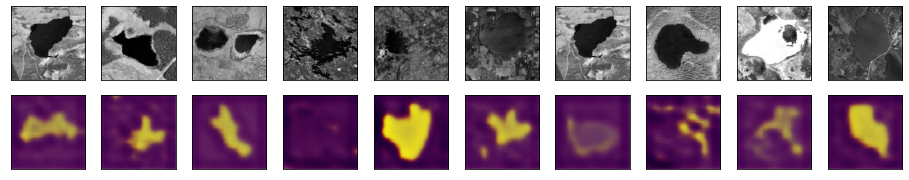

In [174]:
#create a wide (16) and short (3) figure to show 10 images
# and their autoencoded representations stacked top to bottom
plt.figure(figsize=(16, 3))
# loop through 10 sample images
for i in range(10):
    # inputs
    for image, mask in train_dataset.take(i+1):
        subplot = plt.subplot(2, 10, i + 1)
        plt.imshow(image[0,...,0])
        subplot.get_xaxis().set_visible(False) #turn x-axis off
        subplot.get_yaxis().set_visible(False) #turn y-axis off

    # reconstructed inputs
    subplot = plt.subplot(2, 10, i + 11)
    plt.imshow(decoded_imgs[i])
    subplot.get_xaxis().set_visible(False)
    subplot.get_yaxis().set_visible(False)
plt.show()

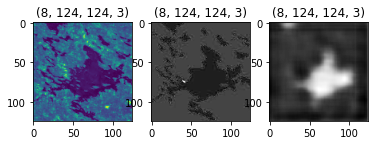

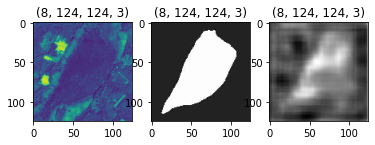

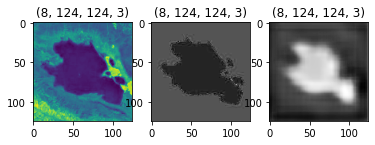

In [193]:
def plot_image_mask(image, mask, predicted):
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    fig, subplots = plt.subplots(nrows=1, ncols=3)
    subplots[0].set_title("{}".format(image.shape))
    subplots[0].imshow(image[0,...,0], cmap='viridis')
    subplots[1].set_title("{}".format(mask.shape))
    subplots[1].imshow(mask[0,...,0], cmap='gray')
    subplots[2].set_title("{}".format(predicted.shape))
    subplots[2].imshow(predicted[0,...,0], cmap='gray')

plt.figure(figsize=(16, 3))
for image, mask in train_dataset.take(3):
    decoded_img = dae.get_image(image)
    plot_image_mask(image, mask, decoded_img)